# SLIX &ndash; Tutorial

This tutorial (Jupyter notebook) shows how the Scattered Light Imaging ToolboX (SLIX) can be used to analyze and evaluate SLI measurements. As an example, we use the SLI image stack of two crossing sections of optic tracts that is available on the EBRAINS data repository. First, we show how different parameter maps (average peak prominence and fiber directions) can be visualized. Then, we show how a vector map can be generated from the fiber directions that represents each fiber direction as colored line (vector).

### General Imports

To start with, you need to import the required packages. Before execution, make sure that you have the rights to read and write in the folder of the notebook.

In [1]:
import sys
sys.path.append('../')

from SLIX import toolbox, visualization
from matplotlib import pyplot as plt
import tifffile
import numpy
import os

import urllib.request

### Download Example File

Next, you need to download the SLI image stack you want to study from the EBRAINS data repository into the current directory of the notebook. We have chosen to download the image stack of two crossing optic tracts from a human optic chiasm.

In [2]:
# Download example image for visualization
input_file_name = './SLI-human-Sub-01_2xOpticTracts_s0037_30um_SLI_105_Stack_3days_registered.nii'
url = 'https://object.cscs.ch/v1/AUTH_227176556f3c4bb38df9feea4b91200c/hbp-d000048_ScatteredLightImaging_pub/Human_Brain/optic_tracts_crossing_sections/SLI-human-Sub-01_2xOpticTracts_s0037_30um_SLI_105_Stack_3days_registered.nii'
urllib.request.urlretrieve(url, input_file_name)

('./SLI-human-Sub-01_2xOpticTracts_s0037_30um_SLI_105_Stack_3days_registered.nii',
 <http.client.HTTPMessage at 0x7f902e18c700>)

### Settings

The following lines set the parameters for the computation and visualization of the parameter maps. The `roisize` variable determines in which resolution the paramter maps are computed. We set the parameter to $1$ (full resolution). If the computation of the parameter maps (peak prominence, direction) takes too long, you can set the paramter to a higher value and compute the parameter maps with lower resolution. Note that this will also distort the resulting values such as the peak prominence or the fiber direction. The other variables define the output folder, and set the size and resolution of the figures. If the figures do not appear correctly, you can change these values.

In [3]:
roisize = 1
output_folder = './output'

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['figure.dpi'] = 100

## Computation of Parameter Maps

Different parameter maps can be generated from an SLI image stack. In the following, we will generate average peak prominence and direction maps to visualize them later on. The user can either use the `SLIXParameterGenerator` introduced in the [README.md](https://github.com/3d-pli/SLIX/blob/master/README.md) or the application programming interface (API).

### Using SLIXParameterGenerator

The following command computes the average peak prominences and up to three fiber direction angles for the dataset we downloaded earlier. In addition to the given roisize (downsampling), all image pixels with low scatterig signal are considered as background (`--with_mask`). The threshold value (`--mask_threshold`) can be adjusted if necessary. The resulting images are stored in the output folder which we defined above.


In [4]:
%run ../bin/SLIXParameterGenerator -i {input_file_name} -o {output_folder} --direction --peakprominence --roisize {roisize} --with_mask --mask_threshold 7

SLI Feature Generator:
Number of threads: 16

Chosen feature maps:
Direction maps: True
Peak maps: False
Peak prominence map: True
Peak width map: False
Peak distance map: False
Optional maps: False

Prominence: 0.08
Peak height: 0.94

./SLI-human-Sub-01_2xOpticTracts_s0037_30um_SLI_105_Stack_3days_registered.nii


  0%|          | 0/1545264 [00:00<?, ?it/s]

Roi finished
Generating parameter maps.


100%|██████████| 1545264/1545264 [01:16<00:00, 20219.19it/s]


Parameter maps generated. Writing images.
Peak prominence written
Crossing directions written


After the parameter maps have been generated and written to the disk, we can read them again using `tifffile`. We are stacking all three direction images to simplify the generation of unit vectors later on.

In [5]:
parameter_map_base_name = os.path.splitext(os.path.basename(input_file_name))[0]
# Read prominence
prominence_image = tifffile.imread(output_folder + '/' + parameter_map_base_name + '_peakprominence.tiff')
# Read all three directions into one image
direction_image = numpy.empty((prominence_image.shape[0], prominence_image.shape[1], 3))
for i in range(3):
    direction_image[:, :, i] = tifffile.imread(output_folder + '/' + parameter_map_base_name + '_dir_'+str(i+1)+'.tiff')

### Using API

First, the SLI image stack is loaded and prepared for the evaluation with SLIX. All image pixels with low scatterig signal are considered as background. The threshold value (`threshold=7`) can be adjusted if necessary.

In [6]:
image = toolbox.read_image(input_file_name)
mask = toolbox.create_background_mask(image, threshold=7)
image[mask, :] = 0
roiset = toolbox.create_roiset(image, roisize)

The following lines compute the average peak prominence for each image pixel in the SLI image stack, yielding a one-dimensional array.

In [8]:
prominence = toolbox.prominence_image(roiset)
prominence_image = toolbox.reshape_array_to_image(prominence, image.shape[0], roisize)

Peak prominence: 100%|██████████| 1545264/1545264 [00:16<00:00, 94215.32it/s] 


The following lines compute the (crossing) fiber direction angles for each image pixel in the SLI image stack, yielding an array with three different direction images (dir1, dir2, dir3).

In [7]:
direction = toolbox.crossing_direction_image(roiset)
direction_image = toolbox.reshape_array_to_image(direction, image.shape[0], roisize)

Direction: 100%|██████████| 1545264/1545264 [01:01<00:00, 24980.36it/s]


## Visualization of Parameter Maps

Using the function `visualize_parameter_map`, different parameter maps can be visualized with different color maps. 

First, we show the average peak prominence in different colors using the standard color map (viridis):

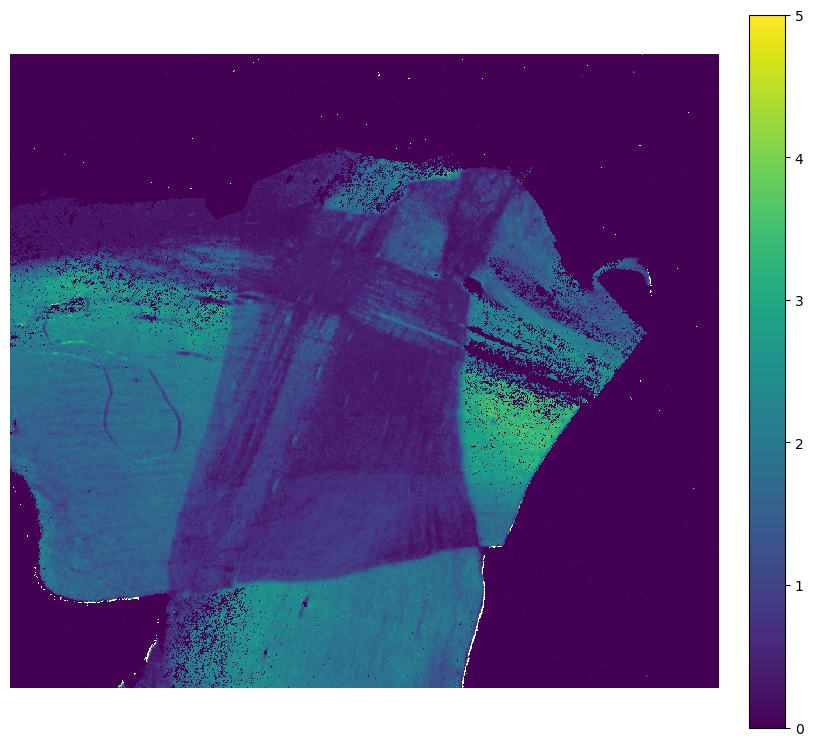

In [10]:
visualization.visualize_parameter_map(prominence_image[:, :], vmax=5)
plt.axis('off')
plt.show()

As expected, the peaks in the SLI profiles have lower prominences in regions with crossing fibers than in regions with parallel fibers, which implies that the signal-to-noise ratio is lower in crossing regions.

Next, we visualize the three direction images (dir1, dir2, dir3) using an HSV color map. The in-plane direction angles were computed from SLI profiles with one, two, four, or six prominent peaks with a pair-wise distance of $(180 \pm 35)^\circ$. All direction angles are in degrees (with $0^\circ$ being along the positive x-axis, and $90^\circ$ along the positive y-axis).

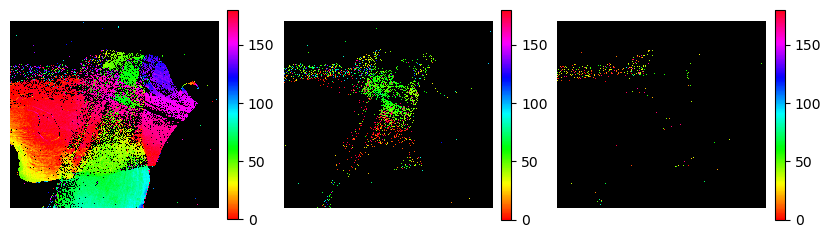

In [9]:
fig, axs = plt.subplots(1, 3)
for i in range(direction_image.shape[-1]):
    visualization.visualize_parameter_map(direction_image[:, :, i], cmap='hsv', fig=fig, ax=axs[i],
                                          vmin=0, vmax=180, colorbar=True)
plt.show()

The left image shows the first detected in-plane nerve fiber direction, i.e. the direction angles of regions with parallel fibers and the first direction angle of regions with several crossing fibers. The other two images show the second and third detected fiber direction in regions with two or three crossing fibers, respectively. As our sample consists only of two crossing fiber bundles, there exist regions where a second fiber orientation is visible (in the middle) but almost no regions with a third fiber orientation (on the right).

## Visualization of Fiber Orientations as Vector Map

For further analysis and to visualize the orientations (vectors) of the fibers, the direction images need to be converted to unit vector maps. For this purpose, SLIX provides the following method:

In [11]:
UnitX, UnitY = visualization.unit_vectors(direction_image)

For each direction angle between 0° and 180°, the x- and y-component of the corresponding unit vector are computed. 
The function `visualize_unit_vectors` allows to represent the fiber directions as vectors (lines) and project them onto the original image (e.g. the maximum intensity values of the SLI image stack). For this purpose, we use the `thinout` parameter. Choosing a value of $1$ means that each image pixel contains a fiber direction vector. To make the vector lines visible on the original image, a higher value should be chosen. The parameter `alpha` determines the transparency of the vector map that is shown on top of the original image.

The following example shows what happens when no thinout is used:

In [12]:
thinout = 1
alpha = 0.8

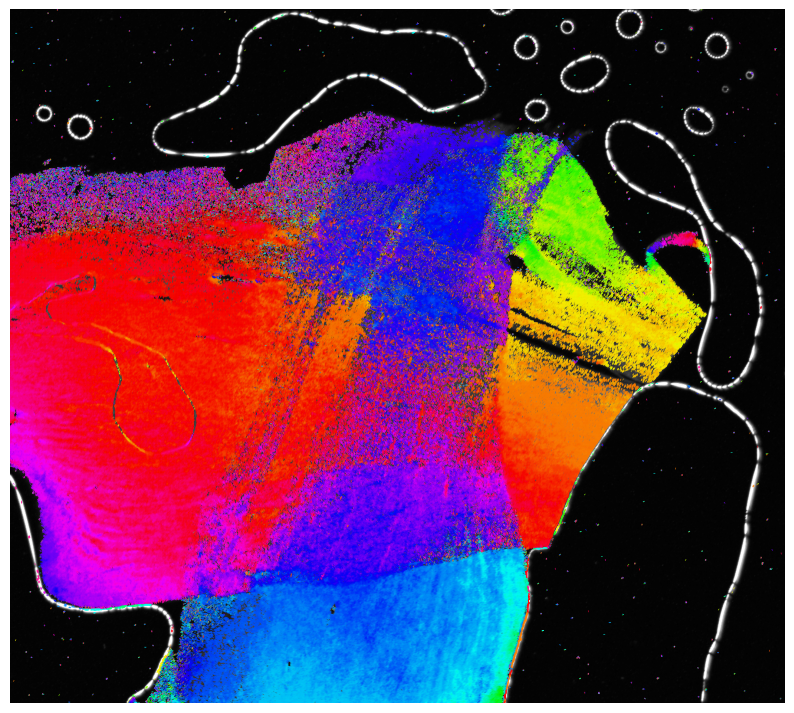

In [13]:
image = toolbox.read_image(input_file_name)

plt.imshow(numpy.max(image[::roisize, ::roisize], axis=-1), cmap='gray')
visualization.visualize_unit_vectors(UnitX, UnitY, thinout=thinout, alpha=alpha)
plt.axis('off')
plt.show()

When zooming into a small region of the image, we obtain:

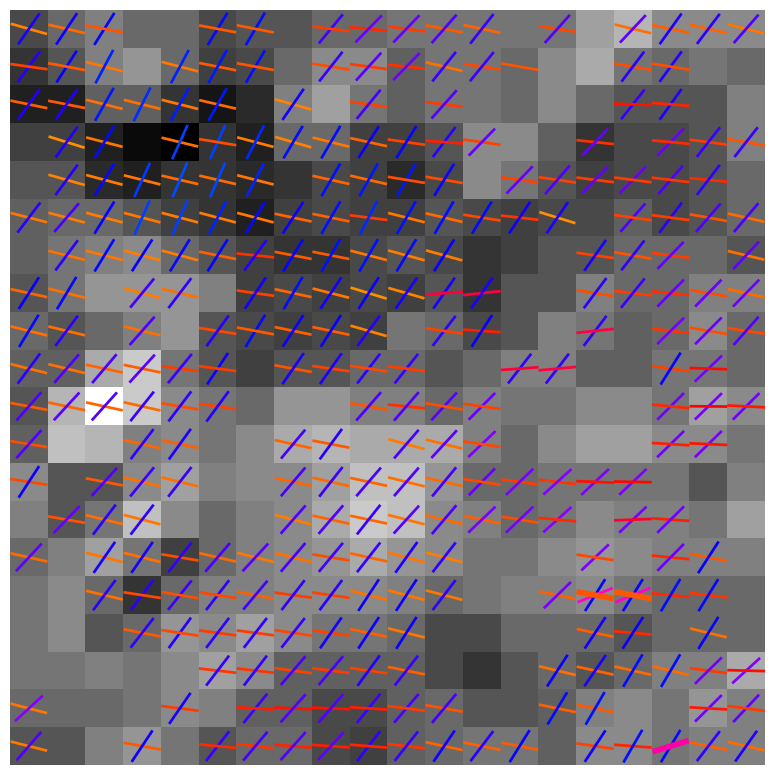

In [14]:
image_roi = image[560//roisize:580//roisize, 610//roisize:630//roisize]
UnitX_roi = UnitX[560//roisize:580//roisize, 610//roisize:630//roisize]
UnitY_roi = UnitY[560//roisize:580//roisize, 610//roisize:630//roisize]


plt.imshow(numpy.max(image_roi, axis=-1), cmap='gray')
visualization.visualize_unit_vectors(UnitX_roi, UnitY_roi)
plt.axis('off')
plt.show()

Each image pixel shows up to three different nerve fiber directions. In this example (two crossing fiber bundles), mostly two different orientations are visible. In regions where the scattering signals are too weak or not reliable, no fiber direction is computed.

To visualize the vector map for the whole tissue sample, a higher value for the `thinout` parameter should be used. When using `thinout=2`, for example, the median direction of 2 x 2 image pixels is computed for each direction image. Image pixels with values of $-1$ (where no fiber direction can be computed) are ignored unless they represent more than a certain fraction (defined by `background_threshold`) of the surrounding pixels. In the example below, we use a thinout of 20 and a background_threshold of 65%.

In [15]:
thinout = 20
alpha = 0.8
background_threshold = 0.65

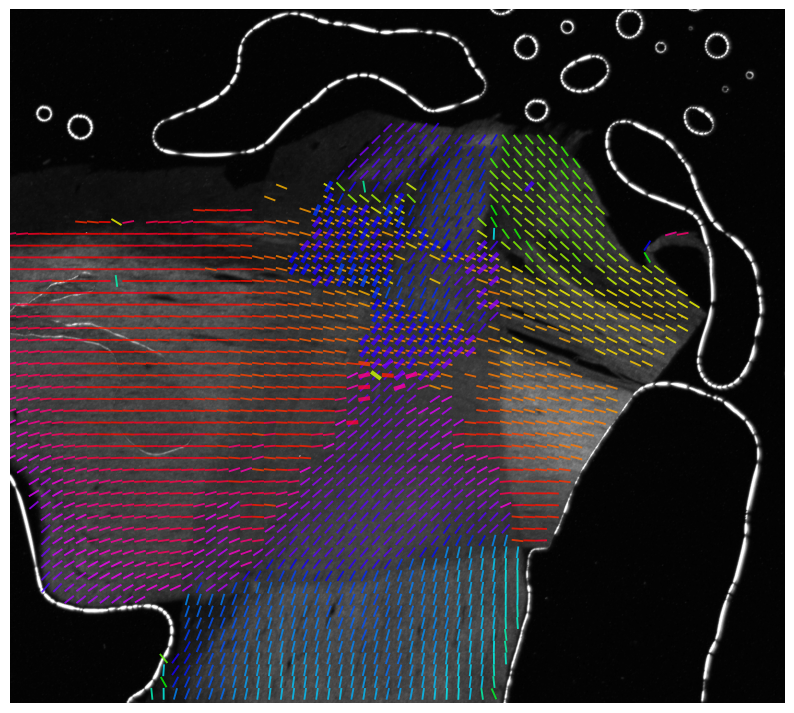

In [16]:
plt.imshow(numpy.max(image[::roisize, ::roisize], axis=-1), cmap='gray') 
visualization.visualize_unit_vectors(UnitX, UnitY, thinout=thinout, alpha=alpha, background_threshold=background_threshold)
plt.axis('off')
plt.show()

## Possible Integration in Tractography Algorithm

To further process the results, the generated unit vectors can be used as input for streamline-based tractrography algorithms. The algorithms use a 3D vector field as input (in form of unit vector maps in x,y,z) and compute the streamlines as sets of consecutive points for later visualization. Common numerical methods are the Euler or Runge-Kutta methods. They both propagate through the vector field by moving a defined step size in the direction of the vector at a given seed point and computing the new direction of propagation by interpolating the neighbored vectors at the new point until the end of the vector field is reached. The Runge-Kutta method requires more computational effort than the Euler method, but yields more accurate results (for more information, see e.g. [Schubert et al. (2017)](https://www.intechopen.com/books/high-resolution-neuroimaging-basic-physical-principles-and-clinical-applications/3d-polarized-light-imaging-portrayed-visualization-of-fiber-architecture-derived-from-3d-pli) and [Nolden et al. (2019)](https://doi.org/10.1007/978-3-658-25326-4_17)). 

When performing the SLI measurement on several consecutive brain sections, registering the resulting SLI image stacks onto each other, and computing the unit vector maps for each brain section, a 3D unit vector field can be generated and used as input for the tractography algorithm.

The following lines show how the raw data (registered SLI image stacks of consecutive brain sections: `Sample_s0001.tiff`, `Sample_s0002.tiff`, etc.) can be prepared for use in in-house developed tractography software, which takes a folder with unit vector maps in NIfTI format as input (`Sample_s0001_UnitX.nii`, `Sample_s0001_UnitY.nii`, `Sample_s0001_UnitZ.nii`, `Sample_s0002_UnitX.nii`, etc.). We assume here that the program is executed in a folder that contains the folder with the raw data (`input_raw`) and two empty folders (`input_tract` and `output_tract`).

```python
from SLIX import toolbox, visualization
import nibabel
import numpy
import os

# loop over all SLI image stacks in the folder 'input_raw'
for file in input_raw:    
    filename_without_extension = os.path.splitext(os.path.basename(file))[0]
    # compute unit vector maps (UnitX, UnitY)
    image = toolbox.read_image(file)
    roiset = toolbox.create_roiset(image)
    directions = toolbox.crossing_direction_image(roiset)
    directions_image = toolbox.reshape_array_to_image(directions, image.shape[0], 1)
    UnitX, UnitY = visualization.unit_vectors(directions_image)
    # save unit vector maps as NIfTI images in the folder 'input_tract' (generate UnitZ filled with zeros)
    nibabel.save(nibabel.Nifti1Image(numpy.swapaxes(UnitX, 0, 1), numpy.eye(4)), 'input_tract/' + filename_without_extension + '_UnitX.nii')
    nibabel.save(nibabel.Nifti1Image(numpy.swapaxes(UnitY, 0, 1), numpy.eye(4)), 'input_tract/' + filename_without_extension + '_UnitY.nii')
    UnitZ = numpy.zeros(UnitX.shape)
    nibabel.save(nibabel.Nifti1Image(numpy.swapaxes(UnitZ, 0, 1), numpy.eye(4)), 'input_tract/' + filename_without_extension + '_UnitZ.nii')

# use unit vector maps in the folder 'input_tract' as input for tractography algorithm and store the results in the folder 'output_tract'
Tractography -i input_tract -o output_tract
```

The following image shows the output of the streamline tractography for a 3D vector field obtained from 3D Polarized Light Imaging (3D-PLI). In contrast to SLI, the 3D-PLI measurement yields only a single fiber orientation vector for each image pixel. The 3D vector field was obtained by measuring 200 consecutive brain sections (70 micron thickness) of a human hemisphere with 3D-PLI (px = 64 x 64 microns), registering the resulting 3D fiber orientations (vectors) for each section onto each other, and performing the tractography on the resulting 3D volume of vectors, using the Runge-Kutta method (4th order), a step size of 60 micron step size, and seed points in every 5th image pixel (in x,y,z).

![](https://jugit.fz-juelich.de/j.reuter/slix/-/blob/assets/tractography.jpg)



